In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Login using e.g. `huggingface-cli login` to access this dataset

df = pd.read_csv("hf://datasets/newsmediabias/fake_news_elections_labelled_data/cleaned_fakenewsdata.csv")

In [2]:
fake_df = pd.read_csv("../data/Fake.csv")
true_df = pd.read_csv("../data/True.csv")


def assign_label(df, label):
    df['label'] = label
    return df

def merge_text(df):
    df['text'] = df['title'] + ' ' + df['text']
    return df

def preprocess_kaggle_df(df, label):
    df = merge_text(df)
    df = assign_label(df, label)
    df = df.drop(['title', 'subject', 'date'], axis=1)
    return df

fake_df = preprocess_kaggle_df(fake_df, 'FAKE')
true_df = preprocess_kaggle_df(true_df, 'REAL')



In [3]:
# pd.concat([fake_df, true_df]).to_csv("../data/cleaned_kaggle_fake_true_data.csv", index=False)

df = pd.concat([fake_df, true_df, df])


In [4]:
df.head(5)

,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,FAKE


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54411 entries, 0 to 9512
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    54411 non-null  object
 1   label   54411 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [6]:
df[df["label"]== "FAKE"].head(5)

,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,FAKE


In [7]:
df['label'].value_counts()

label
REAL    28207
FAKE    26204
Name: count, dtype: int64

Data Preparation
1. Split the data into training and testing sets
2. Text Preprocessing (lowercase, remove special characters, remove stopwords, lemmatization, stemming)

In [8]:
# https://stackoverflow.com/questions/38916452/nltk-download-ssl-certificate-verify-failed
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [9]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tjarkgerken/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tjarkgerken/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tjarkgerken/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
import spacy
nlp = spacy.load("en_core_web_lg")


def preprocess_spacy_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

df['cleaned_text'] = df['text'].apply(preprocess_spacy_text)


KeyboardInterrupt: 

In [10]:
import re
from nltk import WordNetLemmatizer, word_tokenize, sent_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'"""|@+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['cleaned_text'] = df['text'].apply(preprocess_text)

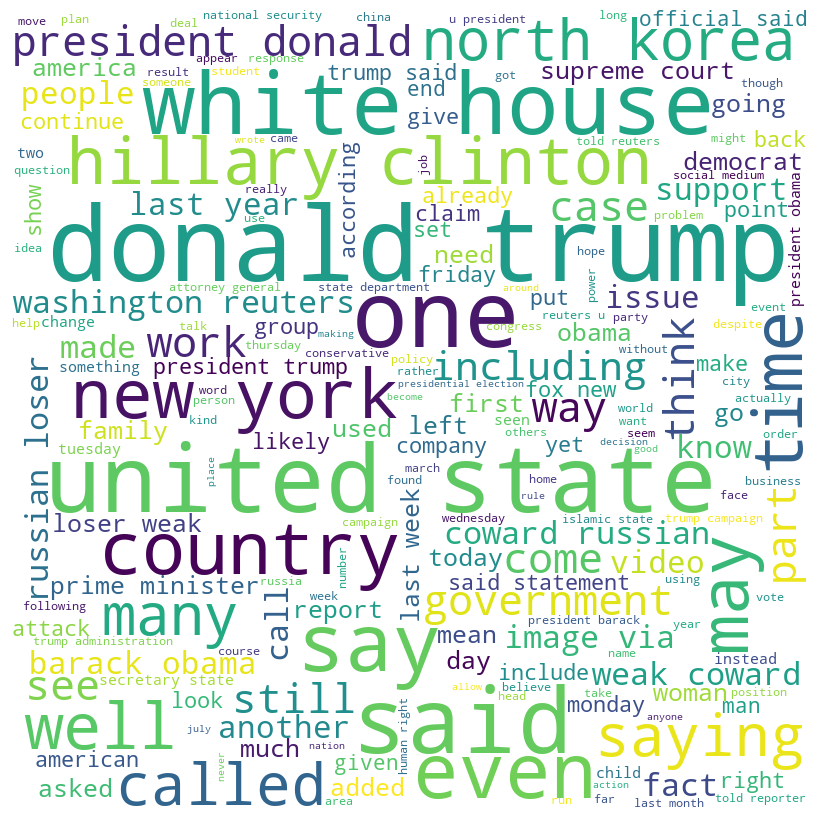

In [55]:
# Generate and display a word cloud for the cleaned text
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned text into a single string
all_text = ' '.join(df['cleaned_text'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(all_text)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Feature Extraction

In [12]:
#from sklearn.feature_extraction.text import CountVectorizer

#vectorizer = CountVectorizer()
#X = vectorizer.fit_transform(df['cleaned_text'])

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['cleaned_text'])

#TODO: Use Word2Vec or GloVe for word embeddings
# wordToVec =  Word2Vec(sentences=df['cleaned_text'], vector_size=100, window=5, min_count=1, workers=4)

In [12]:
from sklearn.model_selection import train_test_split

y = df['label']
y = y.map({'FAKE': 0, 'REAL': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1312)

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingClassifier
from sklearn.svm import SVC, SVR

In [35]:
ensemble = StackingRegressor(
    estimators=[
        ('LinearRegression', LinearRegression()),
        ('rf', RandomForestRegressor(random_state=1312)),
        ('SVR', SVR()),
        ('gbr', GradientBoostingRegressor(random_state=1312)),
        # ("naive_bayes", MultinomialNB()) Classifier
    ],
    final_estimator=GradientBoostingRegressor(random_state=1312))
ensemble.fit(X_train, y_train)


StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('rf', RandomForestRegressor(random_state=1312)),
                              ('SVR', SVR()),
                              ('gbr',
                               GradientBoostingRegressor(random_state=1312))],
                  final_estimator=GradientBoostingRegressor(random_state=1312))

In [37]:
y_pred_ensemble = ensemble.predict(X_test)


In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred_adjusted = [0 if pred < 0.5 else 1 for pred in y_pred]

print(classification_report(y_test, y_pred_adjusted))
print(accuracy_score(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      5198
           1       0.95      0.96      0.96      5685

    accuracy                           0.95     10883
   macro avg       0.95      0.95      0.95     10883
weighted avg       0.95      0.95      0.95     10883

0.9543324450978591


In [14]:
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier

model = (SVC())
model.fit(X_train, y_train)

SVC()

In [15]:
model2 = (RandomForestClassifier())
# model = RandomForestClassifier(n_estimators=100, random_state=1312)
model2.fit(X_train, y_train)

RandomForestClassifier()

In [17]:
model3 = RandomForestRegressor()
model3.fit(X_train, y_train)

RandomForestRegressor()

In [33]:
model5 = GradientBoostingRegressor()
model5.fit(X_train, y_train)

GradientBoostingRegressor()

In [18]:
model4 = SVR()
model4.fit(X_train, y_train)

SVR()

In [39]:
import joblib

joblib.dump(model, './models/model1_svc.pkl')

# Save model2 (RandomForestClassifier)
joblib.dump(model2, './models/model2_rfc.pkl')

# Save model3 (RandomForestRegressor)
joblib.dump(model3, './models/model3_rfr.pkl')

# Save model4 (SVR)
joblib.dump(model4, './models/model4_svr.pkl')
joblib.dump(model5, './models/model5_gbr.pkl')
joblib.dump(ensemble, './models/ensemble.pkl')

['./models/ensemble.pkl']

In [49]:
import joblib

# Load model1 (SVC)
model1 = joblib.load('./models/model1_svc.pkl')

# Load model2 (RandomForestClassifier)
model2 = joblib.load('./models/model2_rfc.pkl')

# Load model3 (RandomForestRegressor)
model3 = joblib.load('./models/model3_rfr.pkl')

# Load model4 (SVR)
model4 = joblib.load('./models/model4_svr.pkl')
ensemble = joblib.load('./models/ensemble.pkl')

In [24]:
y_pred_svc = model.predict(X_test)
y_pred_rfc = model2.predict(X_test)
y_pred_rfr = model3.predict(X_test)
y_pred_svr = model4.predict(X_test)

In [41]:
y_pred_rfr_adj = [0 if pred < 0.5 else 1 for pred in y_pred_rfr]
y_pred_svr_adj = [0 if pred < 0.5 else 1 for pred in y_pred_svr]
y_pred_ensemble_adj = [0 if pred < 0.5 else 1 for pred in y_pred_ensemble]

In [52]:
print(classification_report(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_rfc))
print(classification_report(y_test, y_pred_rfr_adj))
print(classification_report(y_test, y_pred_svr_adj))
print(classification_report(y_test, y_pred_ensemble_adj))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5198
           1       0.95      0.95      0.95      5685

    accuracy                           0.95     10883
   macro avg       0.95      0.95      0.95     10883
weighted avg       0.95      0.95      0.95     10883

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      5198
           1       0.94      0.93      0.93      5685

    accuracy                           0.93     10883
   macro avg       0.93      0.93      0.93     10883
weighted avg       0.93      0.93      0.93     10883

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5198
           1       0.95      0.94      0.95      5685

    accuracy                           0.94     10883
   macro avg       0.94      0.94      0.94     10883
weighted avg       0.94      0.94      0.94     10883

              preci

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Evaluate the model
print(accuracy_score(y_test, y_pred_svc))
print(accuracy_score(y_test, y_pred_rfc))
print(accuracy_score(y_test, y_pred_rfr_adj))
print(accuracy_score(y_test, y_pred_svr_adj))
print(accuracy_score(y_test, y_pred_ensemble_adj))

0.9454194615455297
0.9290636772948635
0.9429385279794175
0.9476247358265184
0.9543324450978591


In [51]:
cnn = "CNN — The fall of Bashar al-Assad’s brutal dictatorship seemed a distant prospect two weeks ago. But Syria’s rebels completed a speedy and stunning march to power on Sunday, starting an uncertain new era for the country. For half a century, the Assad family ruled over Syria with an iron fist, with long-documented reports of mass incarceration torture, extra-judicial killings and atrocities against their own people. On Sunday, after 13 years of civil war that fractured the country, the regime came crashing down. Rebel fighters declared Damacus “liberated” in a video statement on state television, sending Syrian President Bashar al-Assad fleeing to Russia.Many in the country are hopeful for Syria’s next chapter. But the rebels who now control Syria have a complicated past and offer an unpredictable future. Here’s what happened in Syria, what it means, and what might come next. What happened? An armed rebel alliance charged across Syria over 11 days, sweeping through major cities and reigniting a conflict that had been largely static since a 2020 ceasefire agreement. A new rebel coalition, led by the militant group Hayat Tahrir al-Sham (HTS) launched a surprise attack and took control Syria’s largest city Aleppo on November 30, a seismic move that met little resistance from the Syrian army. Syrian and Russian jets had targeted rebels in Aleppo and Idlib but opposition forces seized a second major city of Hama and quickly advanced on Homs – the gateway to the capital Damascus. As Homs fell, rebels encircled and marched into Damascus, declaring Assad overthrown and the city “liberated.” Video showed prisoners being freed from Assad’s notorious detention facilities, rebels and civilians were seen ransacking the presidential palace, with footage revealing his luxurious lifestyle and large car collection. An official source in Russia told CNN the deposed president and his family fled to Moscow and were granted political asylum."

breitbart = "Amid the chaos of the storming of Damascus by the al-Qaeda-linked Islamist Hayat Tahrir al-Sham (HTS) rebel group and the fleeing of former dictator Bashar al-Assad to Moscow, Berlin and Vienna have both announced they will suspend accepting asylum applications from Syrian migrants.German broadcaster NTV reports that a spokesman for the Federal Office for Migration and Refugees (BAMF) confirmed Monday that all asylum applications from Syrians will be temporarily suspended as the situation in the country is “confusing” and therefore no serious judgements on asylum claims can be made for the time being.The agency noted that while this decision will not apply to asylum requests made under the EU migrant sharing Dublin regulations, however, it will apply to the vast majority of Syrian nationals. According to the report, there are currently 47,000 asylum applications pending from Syrians, with 46,081 initial applications, which will now be suspended. A spokeswoman for the Federal Ministry of the Interior said that while asylum cases are typically handled on a case-by-case basis, BAMF has the authority to defer decisions on applications if the situation in the applicant’s home country is unclear and Syria now firmly qualifies as such. Since the move by former German Chancellor Angela Merkel to open the gates of Europe in 2015 amid the civil war in Syria, the country shot to the top of countries of origin for asylum seekers in Germany. At present there are around 975,000 Syrian nationals living in Germany, with around 600,000 residing in the country on a temporary residence permit under some form of asylum protection. Following outrage after a Syrian asylum seeker killed three people and injured several others with a knife at a “festival of diversity” in the city of Solingen in August, there has been increased pressure on the leftist government of Chancellor Olaf Scholz, who is facing a tough re-election bid, to clamp down on mass migration and restart deportations to nations such as Afghanistan and Syria, which were paused over supposed safety concerns sehr nervig"

cnn_vectorized = tfidf.transform([preprocess_text(cnn)])
breitbart_vectorized = tfidf.transform([preprocess_text(breitbart)])
for model_for in [model1, model2, model3, model4, model5, ensemble]:
    prediction = model_for.predict(cnn_vectorized)
    print ("MODEL")
    print(str(model_for))
    print ("CNN")
    print(prediction)
    prediction = model_for.predict(breitbart_vectorized)
    print ("BREITBART")
    print(prediction)


MODEL
SVC()
CNN
[1]
BREITBART
[1]
MODEL
RandomForestClassifier()
CNN
[1]
BREITBART
[1]
MODEL
RandomForestRegressor()
CNN
[0.1]
BREITBART
[0.48]
MODEL
SVR()
CNN
[0.56351717]
BREITBART
[0.69176184]
MODEL
GradientBoostingRegressor()
CNN
[0.14467109]
BREITBART
[0.41196091]
MODEL
StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('rf', RandomForestRegressor(random_state=1312)),
                              ('SVR', SVR()),
                              ('gbr',
                               GradientBoostingRegressor(random_state=1312))],
                  final_estimator=GradientBoostingRegressor(random_state=1312))
CNN
[0.36029661]
BREITBART
[0.7904136]


In [ ]:

prediction1 = model.predict(cnn_vectorized)
prediction2 = model2.predict(cnn_vectorized)
prediction3 = model3.predict(cnn_vectorized)
prediction4 = model4.predict(cnn_vectorized)
prediction5 = model5.predict(cnn_vectorized)
prediction6 = ensemble.predict(cnn_vectorized)
j = 0
for i in [prediction1, prediction2, prediction3, prediction4, prediction5, prediction6]:
    j+=1
    print(j, i)



In [34]:
preprocess_spacy_text(breitbart)

'amid chaos storming Damascus al - Qaeda - link Islamist Hayat Tahrir al - Sham ( HTS ) rebel group fleeing dictator Bashar al - Assad Moscow , Berlin Vienna announce suspend accept asylum application syrian migrant . german broadcaster NTV report spokesman Federal Office Migration Refugees ( BAMF ) confirm Monday asylum application Syrians temporarily suspend situation country " confusing " judgement asylum claim time . agency note decision apply asylum request EU migrant share Dublin regulation , , apply vast majority syrian national . accord report , currently 47,000 asylum application pende Syrians , 46,081 initial application , suspend . spokeswoman Federal Ministry Interior say asylum case typically handle case - - case basis , BAMF authority defer decision application situation applicant home country unclear Syria firmly qualify . german Chancellor Angela Merkel open gate Europe 2015 amid civil war Syria , country shoot country origin asylum seeker Germany . present 975,000 syri

In [35]:
preprocess_text(breitbart)

'amid chaos storming damascus alqaedalinked islamist hayat tahrir alsham hts rebel group fleeing former dictator bashar alassad moscow berlin vienna announced suspend accepting asylum application syrian migrantsgerman broadcaster ntv report spokesman federal office migration refugee bamf confirmed monday asylum application syrian temporarily suspended situation country confusing therefore serious judgement asylum claim made time beingthe agency noted decision apply asylum request made eu migrant sharing dublin regulation however apply vast majority syrian national according report currently asylum application pending syrian initial application suspended spokeswoman federal ministry interior said asylum case typically handled casebycase basis bamf authority defer decision application situation applicant home country unclear syria firmly qualifies since move former german chancellor angela merkel open gate europe amid civil war syria country shot top country origin asylum seeker germany 